### Шаг 1. Откройте файлы с данными

In [1]:
# подключаем зависимости
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    LabelEncoder
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from catboost import cv
from catboost import CatBoostClassifier, Pool

from imblearn.over_sampling import SMOTE

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
data_train = pd.read_csv('/kaggle/input/music-genre/kaggle_music_genre_train.csv')
data_train.head(10)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.480000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.243000,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.228000,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.055800,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.227000,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative
5,43934.0,Eskimo Blue Day - Remastered,0.102000,0.308,392893.0,0.590,0.371000,D,0.1120,-11.703,Major,0.0345,145.758,4-Apr,0.496,Blues
6,23450.0,Living On My Own,0.000234,0.655,218267.0,0.687,0.000024,A,0.0869,-11.789,Minor,0.0337,123.923,4-Apr,0.411,Rock
7,28380.0,Para Machuchar Meu Coracao,0.953000,0.591,309813.0,0.109,0.357000,D#,0.0921,-17.975,Major,0.0449,130.597,4-Apr,0.395,Jazz
8,70054.0,In the Mood,0.195000,0.647,283373.0,0.595,0.000118,A#,0.1290,-8.416,Minor,0.0336,73.478,4-Apr,0.546,Jazz
9,74815.0,20.000 Volts,0.032300,0.537,237000.0,0.962,0.193000,C,0.1580,-2.749,Major,0.1210,160.031,4-Apr,0.430,Electronic


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

Видно, что есть null значения в столбцах key, mode и tempo.

In [4]:
data_test = pd.read_csv('/kaggle/input/music-genre/kaggle_music_genre_test.csv')
data_test.head(10)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.000000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.008320,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.000000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.000000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.014800,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121
5,74228,If You're Going to the City,0.919000,0.516,227267.0,0.192,0.000026,A#,0.1840,-18.983,Minor,0.0650,73.241,4-Apr,0.603
6,39106,21 Questions,0.388000,0.547,224427.0,0.807,0.000091,F#,0.0436,-4.083,Minor,0.3600,79.823,3-Apr,0.919
7,78829,Husbands And Wives,0.653000,0.591,190032.0,0.388,0.000214,F,0.1670,-8.069,Major,0.0267,105.977,3-Apr,0.122
8,91469,Slow Me Down,0.214000,0.597,196160.0,0.602,0.000320,G,0.3130,-4.990,Major,0.0292,91.999,4-Apr,0.262
9,54558,Me Pegó la Gana,0.640000,0.578,168533.0,0.514,0.000000,G,0.1440,-5.990,Major,0.0401,66.342,3-Apr,0.857


In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


В тестовой выборке также есть null значения в столбцах key, mode и tempo.

### Шаг 2. Предобработка и исследовательский анализ данных

Кроме истинных null значений, в описании датасета в Kaggle видно, что duration_ms может приинмать значение -1. Для упрощения работы далее, можем интерпретировать эти данные как null.

In [6]:
for data in [data_train, data_test]:
    data.loc[data['duration_ms'] == -1, 'duration_ms'] = None

Проверим что null встали на свои места.

In [7]:
for data in [data_train, data_test]:
    print(data.isnull().sum())
    print()

instance_id            0
track_name             0
acousticness           0
danceability           0
duration_ms         2009
energy                 0
instrumentalness       0
key                  735
liveness               0
loudness               0
mode                 506
speechiness            0
tempo                442
obtained_date          0
valence                0
music_genre            0
dtype: int64

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms         509
energy                0
instrumentalness      0
key                 158
liveness              0
loudness              0
mode                149
speechiness           0
tempo               121
obtained_date         0
valence               0
dtype: int64



Проверим явные на дубликаты

In [8]:
for data in [data_train, data_test]:
    print(data.duplicated().sum())

0
0


Явных дубликатов нет, поэтому нужно проверить на неявные дубликаты. С учетом того, что есть null данные, будем дубликаты по косвенным признакам, сверяя данные в столбцах, в которых нет пропусков

In [9]:
duplicated_features_subset = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'music_genre']
duplicated_rows = data_train[data_train.duplicated(subset=duplicated_features_subset, keep=False)]
duplicated_rows.sort_values(by=duplicated_features_subset).head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
4945,61145.0,Extreme Ways (Bourne's Legacy),0.000417,0.466,290827.0,0.828,0.2050,B,0.335,-7.898,Minor,0.0518,104.495,4-Apr,0.299,Electronic
18071,23448.0,Extreme Ways (Bourne's Legacy) - Original Version,0.000417,0.466,290827.0,0.828,0.2050,B,0.335,-7.898,Minor,0.0518,104.495,4-Apr,0.299,Electronic
12175,82029.0,TTU (Too Turnt Up) (feat. Waka Flocka Flame),0.003990,0.579,241702.0,0.790,0.1350,NaN,0.101,-4.683,Minor,0.0468,144.998,4-Apr,0.233,Electronic
15429,78576.0,TTU (Too Turnt Up),0.003990,0.579,241702.0,0.790,0.1350,NaN,0.101,-4.683,Minor,0.0468,144.998,4-Apr,0.233,Electronic
10089,21594.0,Forever - FuntCase Remix,0.013400,0.312,321600.0,0.981,0.0619,F,0.289,-2.788,Minor,0.3800,149.600,4-Apr,0.043,Electronic


Проанализируем дубликаты на пропуски, чтобы по возможности их обработать.

In [10]:
duplicated_rows.isnull().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 2
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

Посмотрим что за стоки с пропущенным key

In [11]:
duplicated_rows[duplicated_rows['key'].isnull()]

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
12175,82029.0,TTU (Too Turnt Up) (feat. Waka Flocka Flame),0.00399,0.579,241702.0,0.79,0.135,NaN,0.101,-4.683,Minor,0.0468,144.998,4-Apr,0.233,Electronic
15429,78576.0,TTU (Too Turnt Up),0.00399,0.579,241702.0,0.79,0.135,NaN,0.101,-4.683,Minor,0.0468,144.998,4-Apr,0.233,Electronic


key пропущен в обоих записях. удалим дубли

In [12]:
data_train = data_train.drop_duplicates(subset=duplicated_features_subset, ignore_index=True)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20387 entries, 0 to 20386
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20387 non-null  float64
 1   track_name        20387 non-null  object 
 2   acousticness      20387 non-null  float64
 3   danceability      20387 non-null  float64
 4   duration_ms       18378 non-null  float64
 5   energy            20387 non-null  float64
 6   instrumentalness  20387 non-null  float64
 7   key               19653 non-null  object 
 8   liveness          20387 non-null  float64
 9   loudness          20387 non-null  float64
 10  mode              19881 non-null  object 
 11  speechiness       20387 non-null  float64
 12  tempo             19945 non-null  float64
 13  obtained_date     20387 non-null  object 
 14  valence           20387 non-null  float64
 15  music_genre       20387 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

7 дубликатов удалили. Теперь проверим, есть ли такие дубликаты, у которых разные жанры.

In [13]:
duplicated_features_subset.pop()

'music_genre'

In [14]:
duplicated_rows_train = data_train[data_train.duplicated(subset=duplicated_features_subset, keep=False)]
duplicated_rows_train.sort_values(by=duplicated_features_subset).head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
18765,71940.0,Beyond The Stars,0.000007,0.406,222049.0,0.952,0.025200,G#,0.198,-2.987,Major,0.0424,88.563,4-Apr,0.534,Alternative
20322,72215.0,Beyond The Stars,0.000007,0.406,222049.0,0.952,0.025200,G#,0.198,-2.987,Major,0.0424,88.563,4-Apr,0.534,Rap
6479,51362.0,This Calling,0.000011,0.542,218533.0,0.986,0.000798,D,0.313,-2.663,Minor,0.0968,108.059,4-Apr,0.265,Rap
19972,36436.0,This Calling,0.000011,0.542,218533.0,0.986,0.000798,D,0.313,-2.663,Minor,0.0968,108.059,4-Apr,0.265,Alternative
875,43168.0,Sex,0.000013,0.403,206987.0,0.971,0.000022,D,0.488,-4.159,Major,0.1120,148.324,4-Apr,0.184,Alternative


In [15]:
duplicated_rows_train['instance_id'].count()

1383

Заодно посмотрим на дубликаты в тестовой выборке

In [16]:
duplicated_rows_test = data_test[data_test.duplicated(subset=duplicated_features_subset, keep=False)]
duplicated_rows_test.sort_values(by=duplicated_features_subset).head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
1062,80511,Higher,0.000051,0.459,316733.0,0.830,0.000140,D,0.206,-6.254,Major,0.0364,155.826,4-Apr,0.431
3329,57178,Higher,0.000051,0.459,NaN,0.830,0.000140,D,0.206,-6.254,Major,0.0364,155.826,4-Apr,0.431
532,37894,Whatever,0.000145,0.543,206200.0,0.880,0.053200,F,0.333,-4.870,NaN,0.1210,122.129,4-Apr,0.606
2360,64978,Whatever,0.000145,0.543,206200.0,0.880,0.053200,F,0.333,-4.870,Major,0.1210,122.129,4-Apr,0.606
821,46274,I Will Not Bow,0.000192,0.543,NaN,0.952,0.000008,G#,0.380,-3.650,Major,0.0668,107.942,4-Apr,0.591


In [17]:
duplicated_rows_test['instance_id'].count()

81

Выводы которые можно сделать:
- т.к. в обучающей выборе дубликаты идентифицируются разными жанрами - это будет мешать обучению моделей - нам придется как-то эту ситуацию обработать.
- т.к. в тестовой выборке тоже есть дубликаты - мы можем использовать информацию о дубликатах в обоих выборках для того, чтобы попробовать заполнить null-значения.

In [18]:
duplicated_rows_test.isnull().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         8
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                3
speechiness         0
tempo               2
obtained_date       0
valence             0
dtype: int64

In [19]:
duplicated_rows_test[duplicated_rows_test.isnull().any(axis=1)].sort_values(by=duplicated_features_subset)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
3329,57178,Higher,0.000051,0.459,NaN,0.830,0.000140,D,0.2060,-6.254,Major,0.0364,155.826,4-Apr,0.431
532,37894,Whatever,0.000145,0.543,206200.0,0.880,0.053200,F,0.3330,-4.870,NaN,0.1210,122.129,4-Apr,0.606
821,46274,I Will Not Bow,0.000192,0.543,NaN,0.952,0.000008,G#,0.3800,-3.650,Major,0.0668,107.942,4-Apr,0.591
2390,74375,IDGAF,0.003120,0.728,247320.0,0.550,0.000000,D,0.0871,-6.049,NaN,0.3790,139.863,4-Apr,0.305
2455,21331,IDGAF,0.003120,0.728,NaN,0.550,0.000000,D,0.0871,-6.049,Major,0.3790,139.863,4-Apr,0.305
3932,63707,Fortress,0.015100,0.477,NaN,0.737,0.001450,B,0.0893,-5.980,Minor,0.0346,121.833,4-Apr,0.325
3848,71584,Hasta Luego - Bonus,0.035900,0.769,NaN,0.505,0.000106,B,0.1070,-6.882,Minor,0.2520,140.063,4-Apr,0.297
2138,51470,Do Not Disturb,0.119000,0.597,252667.0,0.564,0.000000,C#,0.2290,-6.968,Major,0.2300,NaN,4-Apr,0.233
1971,80625,Dating in the 90s,0.171000,0.595,155498.0,0.533,0.014300,G#,0.0959,-8.430,NaN,0.0407,109.984,4-Apr,0.145
4285,33135,What A Beautiful Day - Final Version,0.238000,0.576,NaN,0.814,0.000001,F#,0.0984,-5.893,Major,0.0350,98.022,4-Apr,0.744


Действительно можно заполнить пропуски по тем данным, что у нас есть в дубликатах. Чтобы заполнить пропуски, нам нужно однозначно идентифицировать треки. Введем для этого признак hash, рассчитанный на базе колонок, в которых нет пропусков.

In [20]:
def get_hash(row):
   return hash(tuple(row[duplicated_features_subset]))

data_train['hash'] = data_train.apply(get_hash, axis=1)
data_test['hash'] = data_test.apply(get_hash, axis=1)

In [21]:
data_train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,hash
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country,-2961931833227601678
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock,6750008447695493461
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative,-6095787182916941504
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop,8910384357504882523
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative,-4480110256883792228


Объединим все данные в один большой справочник

In [22]:
data_all = pd.concat([data_train, data_test], axis=0, join='outer').reset_index()

Произведем поиск пропущенных значений среди всех данных которые у нас есть.

In [23]:
nullable_features = ['duration_ms', 'mode', 'key', 'tempo']
for data in [data_train, data_test]:
    for nullable_feature in nullable_features:
        hash_list = data[data[nullable_feature].isnull()]['hash']
        for hash_value in hash_list:
            values = data_all[(data_all['hash'] == hash_value)&(~data_all[nullable_feature].isnull())]
            if(not values.empty):
                value = values.iloc[0][nullable_feature]
                data.loc[(data['hash'] == hash_value)&(data[nullable_feature].isnull()), nullable_feature] = value

Удалим дубликаты из обучающей выборки. Оставим только первый жанр. Будем считать, что он основной.

In [24]:
data_train = data_train.drop_duplicates(subset=duplicated_features_subset, keep='first', ignore_index=True)

Посмотрим сколько осталось null значений.

In [25]:
for data in [data_train, data_test]:
    print(data.isnull().sum())
    print()

instance_id            0
track_name             0
acousticness           0
danceability           0
duration_ms         1842
energy                 0
instrumentalness       0
key                  679
liveness               0
loudness               0
mode                 469
speechiness            0
tempo                408
obtained_date          0
valence                0
music_genre            0
hash                   0
dtype: int64

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms         469
energy                0
instrumentalness      0
key                 150
liveness              0
loudness              0
mode                139
speechiness           0
tempo               107
obtained_date         0
valence               0
hash                  0
dtype: int64



Удалим колонки, которые не будем использовать в анализе

In [26]:
features_train = data_train.drop(['instance_id', 'track_name', 'obtained_date', 'hash'], axis=1)
features_test = data_test.drop(['instance_id', 'track_name', 'obtained_date', 'hash'], axis=1)

In [27]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19687 entries, 0 to 19686
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      19687 non-null  float64
 1   danceability      19687 non-null  float64
 2   duration_ms       17845 non-null  float64
 3   energy            19687 non-null  float64
 4   instrumentalness  19687 non-null  float64
 5   key               19008 non-null  object 
 6   liveness          19687 non-null  float64
 7   loudness          19687 non-null  float64
 8   mode              19218 non-null  object 
 9   speechiness       19687 non-null  float64
 10  tempo             19279 non-null  float64
 11  valence           19687 non-null  float64
 12  music_genre       19687 non-null  object 
dtypes: float64(10), object(3)
memory usage: 2.0+ MB


In [28]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      5099 non-null   float64
 1   danceability      5099 non-null   float64
 2   duration_ms       4630 non-null   float64
 3   energy            5099 non-null   float64
 4   instrumentalness  5099 non-null   float64
 5   key               4949 non-null   object 
 6   liveness          5099 non-null   float64
 7   loudness          5099 non-null   float64
 8   mode              4960 non-null   object 
 9   speechiness       5099 non-null   float64
 10  tempo             4992 non-null   float64
 11  valence           5099 non-null   float64
dtypes: float64(10), object(2)
memory usage: 478.2+ KB


tempo является числовым признаком, чтобы обработать пропуски - заменим их на медиану в каждом жанре отдельно. в тестовой выборке на общую медиану.

Прежде чем рассчитывать медиану, посмотрим на адекватность данных

In [29]:
for data in [features_train, features_test]:
    print(data['tempo'].describe())
    print()

count    19279.000000
mean       120.991820
std         30.471175
min         34.765000
25%         95.938500
50%        120.015000
75%        141.983000
max        220.041000
Name: tempo, dtype: float64

count    4992.000000
mean      121.276183
std        29.883164
min        37.114000
25%        96.071750
50%       120.055500
75%       141.964500
max       216.029000
Name: tempo, dtype: float64



Данные в порядке.

In [30]:
genre_tempo_median = features_train.groupby(by='music_genre')['tempo'].median().reset_index(name='median')
genre_tempo_median

,music_genre,median
0,Alternative,120.2215
1,Anime,128.0020
2,Blues,119.1460
3,Classical,95.4900
4,Country,121.7680
5,Electronic,126.0000
6,Hip-Hop,120.9670
7,Jazz,105.3600
8,Rap,120.0200
9,Rock,120.9450


Прием для рассчета медианы по жанру мы будем использовать несколько раз, поэтому объявим функцию.

In [31]:
def fill_median(f_train, f_test, f_name, genre_medians):
    for i, row in genre_medians.iterrows():
        selector = (f_train['music_genre'] == row['music_genre'])&(f_train[f_name].isnull())
        f_train.loc[selector, f_name] = row['median']
    
    f_test.loc[f_test[f_name].isnull(), f_name] = f_test[f_name].median()

In [32]:
fill_median(features_train, features_test, 'tempo', genre_tempo_median)

In [33]:
for data in [features_train, features_test]:
    print(data.isnull().sum())
    print()

acousticness           0
danceability           0
duration_ms         1842
energy                 0
instrumentalness       0
key                  679
liveness               0
loudness               0
mode                 469
speechiness            0
tempo                  0
valence                0
music_genre            0
dtype: int64

acousticness          0
danceability          0
duration_ms         469
energy                0
instrumentalness      0
key                 150
liveness              0
loudness              0
mode                139
speechiness           0
tempo                 0
valence               0
dtype: int64



Теперь этот же прием применим к длительности.

In [34]:
genre_duration_median = features_train.groupby(by='music_genre')['duration_ms'].median().reset_index(name='median')
fill_median(features_train, features_test, 'duration_ms', genre_duration_median)

In [35]:
for data in [features_train, features_test]:
    print(data.isnull().sum())
    print()

acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 679
liveness              0
loudness              0
mode                469
speechiness           0
tempo                 0
valence               0
music_genre           0
dtype: int64

acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 150
liveness              0
loudness              0
mode                139
speechiness           0
tempo                 0
valence               0
dtype: int64



Стоит проверить категориальные признаки на уникальность.

In [36]:
for data in [features_train, features_test]:
    print('key:')
    print(data['key'].sort_values().unique())
    print('mode:')
    print(data['mode'].sort_values().unique())

key:
['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#' nan]
mode:
['Major' 'Minor' nan]
key:
['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#' nan]
mode:
['Major' 'Minor' nan]


In [37]:
features_train.pivot_table(index="music_genre", columns="mode", values='acousticness', aggfunc="count")

mode,Major,Minor
music_genre,,
Alternative,1513,880
Anime,1139,705
Blues,1951,793
Classical,889,447
Country,1780,239
Electronic,1309,1171
Hip-Hop,570,459
Jazz,617,584
Rap,1185,1031


Во всех жанрах мажор встречается чаще, чем минор. Заполним пропуски по самой часто встречающейся моде.

In [38]:
for data in [features_train, features_test]:
    mode = data['mode'].mode()[0];
    data['mode'] = data['mode'].fillna(mode)

In [39]:
features_train.pivot_table(index="music_genre", columns="key", values='acousticness', aggfunc="count")

key,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
music_genre,,,,,,,,,,,,
Alternative,221,128,208,267,220,251,67,197,189,182,277,165
Anime,183,91,121,208,181,202,67,145,166,121,225,118
Blues,365,125,186,350,170,359,64,212,244,96,411,126
Classical,123,74,74,159,108,176,79,117,117,65,165,74
Country,241,94,143,233,151,231,79,177,136,115,276,123
Electronic,218,188,227,222,358,198,49,179,212,185,265,154
Hip-Hop,79,94,106,73,207,81,24,49,82,65,69,78
Jazz,113,112,63,134,91,96,46,102,138,62,134,91
Rap,163,175,194,191,399,186,56,123,152,158,200,190


По этой таблице сложно сделать вывод. Во всех жанрах присутствуют все ключевые ноты. Заполним пропуски заглушкой

In [40]:
for data in [features_train, features_test]:
    key = data['key'].mode()[0];
    data['key'] = data['key'].fillna('unknown')

In [41]:
for data in [features_train, features_test]:
    print(data.isnull().sum())
    print()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
dtype: int64



Разобрались с null значениями.

**Проанализируем числовые признаки на адекватность значений.**

In [42]:
for data in [features_train, features_test]:
    print(data['acousticness'].describe())
    print()

count    19687.000000
mean         0.278063
std          0.323577
min          0.000000
25%          0.015500
50%          0.123000
75%          0.479000
max          0.996000
Name: acousticness, dtype: float64

count    5099.000000
mean        0.276324
std         0.322657
min         0.000002
25%         0.016600
50%         0.120000
75%         0.460000
max         0.996000
Name: acousticness, dtype: float64



Нужно посмотреть что за 0 в обучающей выборке.

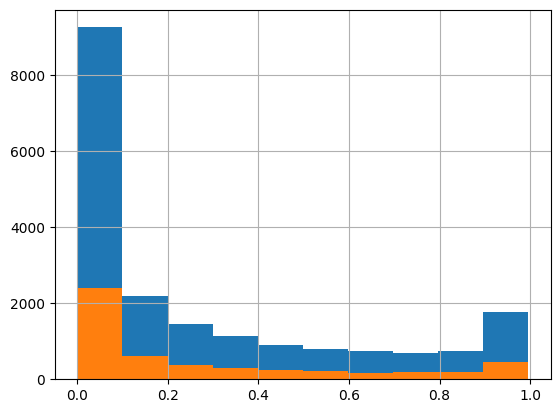

In [43]:
for data in [features_train, features_test]:
    data['acousticness'].hist()

In [44]:
for data in [features_train, features_test]:
    print(data[data['acousticness'] == 0]['acousticness'].count())

1
0


Скорей всего это реальное значение, но если нет - не сильно будет влиять на обучение.

In [45]:
for data in [features_train, features_test]:
    print(data['danceability'].describe())
    print()

count    19687.000000
mean         0.560575
std          0.172172
min          0.060000
25%          0.450000
50%          0.569000
75%          0.681000
max          0.978000
Name: danceability, dtype: float64

count    5099.000000
mean        0.561888
std         0.170502
min         0.059600
25%         0.451000
50%         0.568000
75%         0.681000
max         0.977000
Name: danceability, dtype: float64



Здесь все адекватно

In [46]:
for data in [features_train, features_test]:
    print(data['duration_ms'].describe())
    print()

count    1.968700e+04
mean     2.434500e+05
std      1.052476e+05
min      1.550900e+04
25%      1.956025e+05
50%      2.270670e+05
75%      2.669360e+05
max      4.497994e+06
Name: duration_ms, dtype: float64

count    5.099000e+03
mean     2.408488e+05
std      1.084075e+05
min      2.275000e+04
25%      1.942335e+05
50%      2.260260e+05
75%      2.649585e+05
max      4.497994e+06
Name: duration_ms, dtype: float64



Для удобства сразу переведу в секунды

In [47]:
features_train['duration_sec'] = features_train['duration_ms'] / 1000
features_test['duration_sec'] = features_test['duration_ms'] / 1000
features_train = features_train.drop('duration_ms', axis=1)
features_test = features_test.drop('duration_ms', axis=1)

In [48]:
for data in [features_train, features_test]:
    print(data['duration_sec'].describe())
    print()

count    19687.000000
mean       243.450026
std        105.247560
min         15.509000
25%        195.602500
50%        227.067000
75%        266.936000
max       4497.994000
Name: duration_sec, dtype: float64

count    5099.000000
mean      240.848840
std       108.407547
min        22.750000
25%       194.233500
50%       226.026000
75%       264.958500
max      4497.994000
Name: duration_sec, dtype: float64



Все адекватно.

In [49]:
for data in [features_train, features_test]:
    print(data['energy'].describe())
    print()

count    19687.000000
mean         0.623333
std          0.252777
min          0.001010
25%          0.466500
50%          0.665000
75%          0.830000
max          0.999000
Name: energy, dtype: float64

count    5099.000000
mean        0.622030
std         0.251829
min         0.001540
25%         0.465000
50%         0.660000
75%         0.826000
max         0.999000
Name: energy, dtype: float64



Все адекватно.

In [50]:
for data in [features_train, features_test]:
    print(data['instrumentalness'].describe())
    print()

count    19687.000000
mean         0.163701
std          0.309374
min          0.000000
25%          0.000000
50%          0.000164
75%          0.097000
max          0.996000
Name: instrumentalness, dtype: float64

count    5099.000000
mean        0.165198
std         0.311940
min         0.000000
25%         0.000000
50%         0.000157
75%         0.092750
max         0.994000
Name: instrumentalness, dtype: float64



Посмотрим на 0

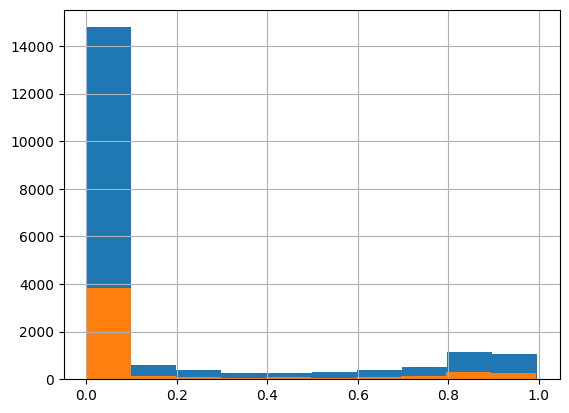

In [51]:
for data in [features_train, features_test]:
    data['instrumentalness'].hist()

In [52]:
for data in [features_train, features_test]:
    print(data[data['instrumentalness'] == 0]['instrumentalness'].count())

5700
1510


Слишком большое количество имеет значение 0. Проверим распределение по жанрам.

In [53]:
features_train[features_train['instrumentalness'] == 0].groupby(by='music_genre')['instrumentalness'].count()

music_genre
Alternative     701
Anime           562
Blues           449
Classical        49
Country         993
Electronic      120
Hip-Hop         666
Jazz            129
Rap            1457
Rock            574
Name: instrumentalness, dtype: int64

Сложно сделать какое-то предположение. Но как будто бы получается, что и классическая музыка бывает со словами (Classical = 49). Принимаю решение заменить 0 на медиану по жанрам.

In [54]:
features_train.loc[features_train['instrumentalness'] == 0, 'instrumentalness'] = None
features_test.loc[features_test['instrumentalness'] == 0, 'instrumentalness'] = None
genre_instrumentalness_median = features_train.groupby(by='music_genre')['instrumentalness'].median().reset_index(name='median')
fill_median(features_train, features_test, 'instrumentalness', genre_instrumentalness_median)

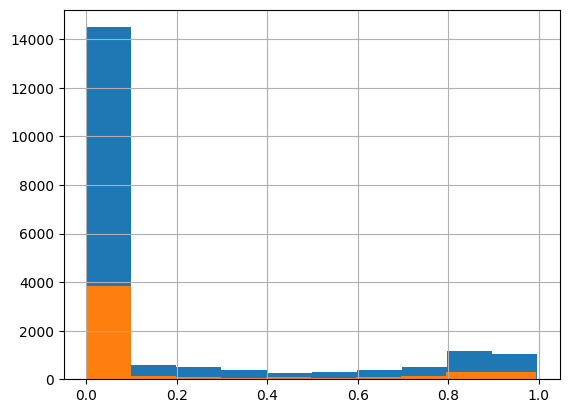

In [55]:
for data in [features_train, features_test]:
    data['instrumentalness'].hist()

In [56]:
for data in [features_train, features_test]:
    print(data['liveness'].describe())
    print()

count    19687.000000
mean         0.198569
std          0.167436
min          0.013600
25%          0.097200
50%          0.129000
75%          0.252000
max          1.000000
Name: liveness, dtype: float64

count    5099.000000
mean        0.197924
std         0.166241
min         0.020400
25%         0.096950
50%         0.129000
75%         0.248000
max         0.990000
Name: liveness, dtype: float64



Все адекватно.

In [57]:
for data in [features_train, features_test]:
    print(data['loudness'].describe())

count    19687.000000
mean        -8.607776
std          5.557403
min        -44.406000
25%        -10.332000
50%         -7.079000
75%         -5.062000
max          3.744000
Name: loudness, dtype: float64
count    5099.000000
mean       -8.630186
std         5.619766
min       -46.122000
25%       -10.231000
50%        -7.135000
75%        -5.127000
max         1.949000
Name: loudness, dtype: float64


Все адекватно.

In [58]:
for data in [features_train, features_test]:
    print(data['speechiness'].describe())
    print()

count    19687.000000
mean         0.090534
std          0.097203
min          0.022300
25%          0.035600
50%          0.048800
75%          0.093600
max          0.942000
Name: speechiness, dtype: float64

count    5099.000000
mean        0.092718
std         0.100130
min         0.022600
25%         0.035700
50%         0.048700
75%         0.096550
max         0.918000
Name: speechiness, dtype: float64



Все адекватно.

In [59]:
for data in [features_train, features_test]:
    print(data['valence'].describe())
    print()

count    19687.000000
mean         0.463458
std          0.243841
min          0.000000
25%          0.270000
50%          0.456000
75%          0.652000
max          0.992000
Name: valence, dtype: float64

count    5099.000000
mean        0.465593
std         0.244217
min         0.020500
25%         0.272000
50%         0.458000
75%         0.650000
max         0.982000
Name: valence, dtype: float64



Посмотрим на 0

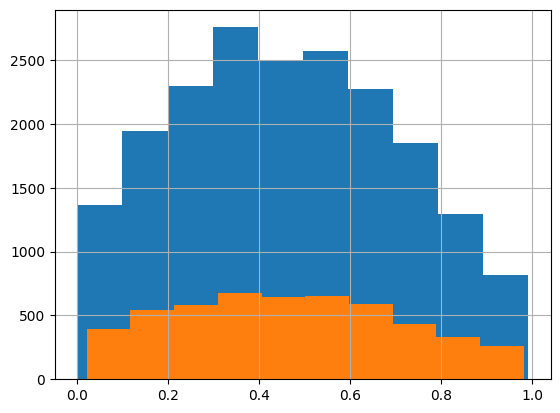

In [60]:
for data in [features_train, features_test]:
    data['valence'].hist()

In [61]:
for data in [features_train, features_test]:
    print(data[data['valence'] == 0]['valence'].count())

1
0


Оставляем.

Резюме. Разобрались с null значениями, проверили входные признаки на адекватность значений.

**Вводим новые признаки.**

В описании данных сказано как интерпретировать признаки liveness и speechiness.
Заменим их на категориальные.

In [62]:
def get_liveness(row):
    l = row['liveness']
    if l > 0.8:
        return 'live'
    else:
        return 'recorded'

features_train['liveness'] = features_train.apply(get_liveness, axis=1)
features_test['liveness'] = features_test.apply(get_liveness, axis=1)

In [63]:
def get_speechiness(row):
    l = row['speechiness']
    if l > 0.66:
        return 'vocal'
    elif l < 0.33:
        return 'musical'
    else:
        return 'mixed'

features_train['speechiness'] = features_train.apply(get_speechiness, axis=1)
features_test['speechiness'] = features_test.apply(get_speechiness, axis=1)

**Проверка на мультиколлинеарность.**

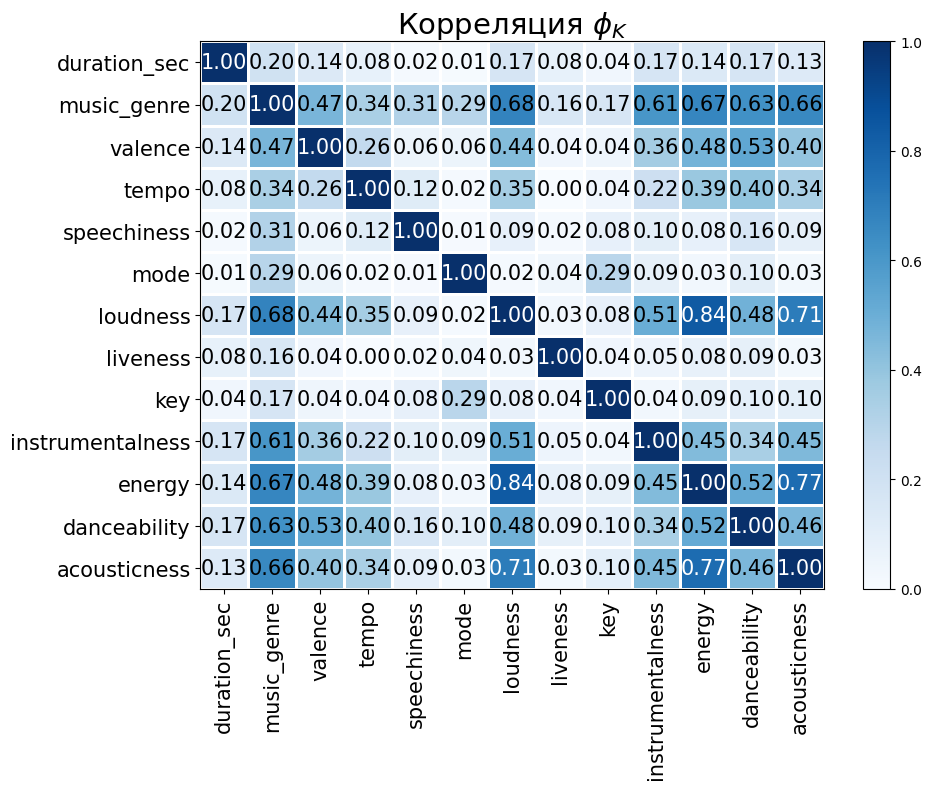

In [64]:
interval_cols = ['acousticness', 'danceability', 'duration_sec', 'energy', 'instrumentalness', 'loudness', 'tempo', 'valence']
phik_overview = features_train.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

Нашел на википедии https://ru.wikipedia.org/wiki/%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BA%D0%BE%D0%BB%D0%BB%D0%B8%D0%BD%D0%B5%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C "Для обнаружения мультиколлинеарности факторов можно проанализировать непосредственно корреляционную матрицу факторов. Уже наличие больших по модулю (выше 0,7-0,8) значений коэффициентов парной корреляции свидетельствует о возможных проблемах с качеством получаемых оценок."
Примем, что коэффициент должен быть не выше 0.7

In [65]:
CORRELATION_LIMIT = 0.75
for i, row in phik_overview.iterrows():
    for j, value in row.items():
        if(i > j and np.abs(value) > CORRELATION_LIMIT):
            print(i, j, value)

energy acousticness 0.7678900709189707
loudness energy 0.8396469198736145


energy коррелирует с acousticness и loudness

При оценке корреляций мы должны обращать внимание не только на коэффициенты, но и на их статистическую значимость. Потому что, в конце концов, большая корреляция может оказаться статистически незначимой, и наоборот.

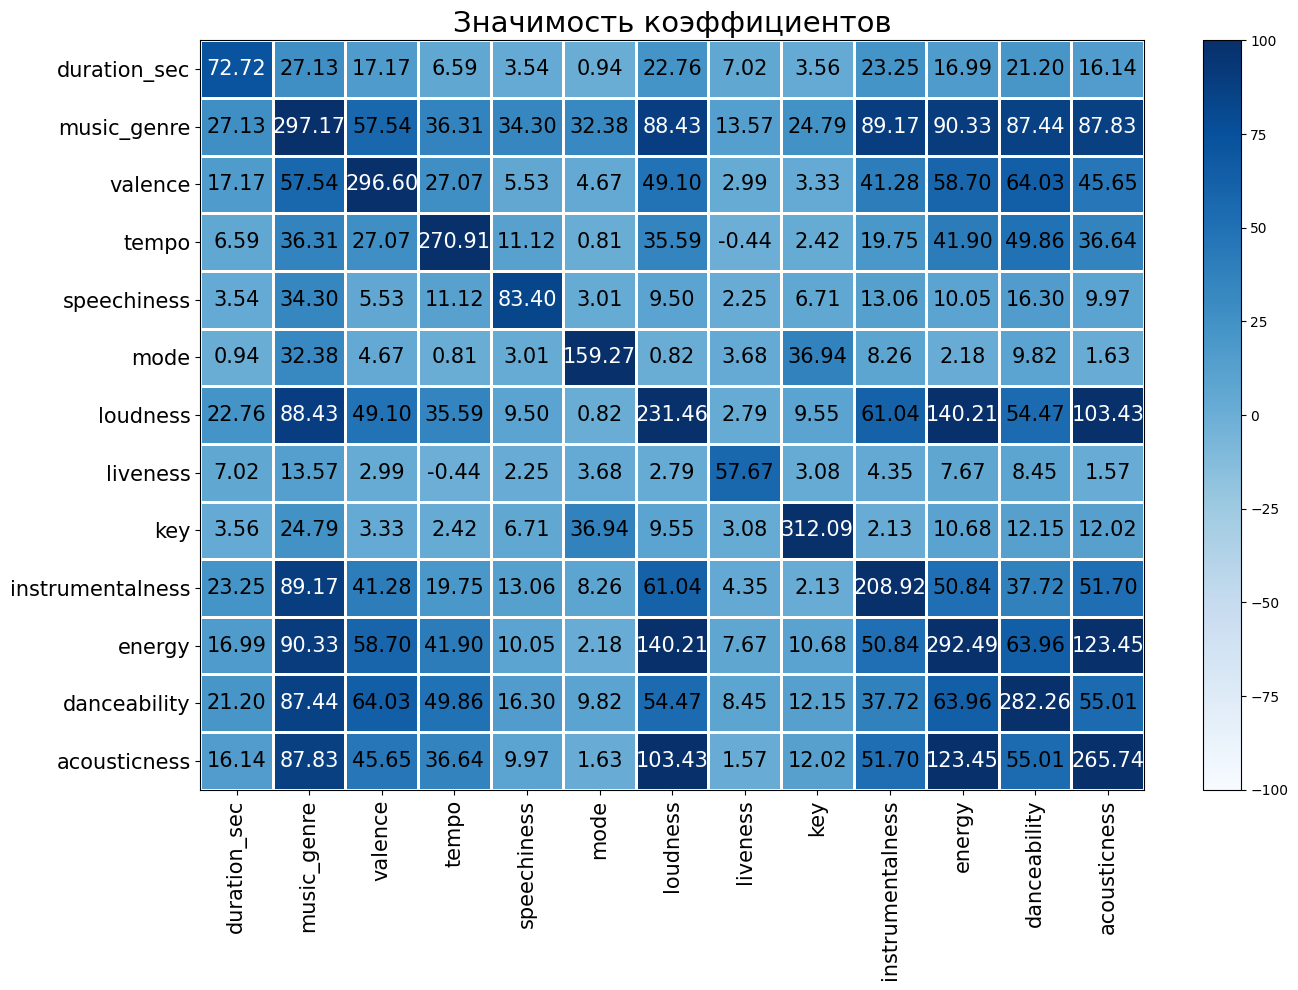

In [66]:
significance_overview = features_train.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-100, vmax=100, title="Значимость коэффициентов", 
                        color_map="Blues",
                        usetex=False, fontsize_factor=1.5, figsize=(14, 10))
plt.tight_layout()

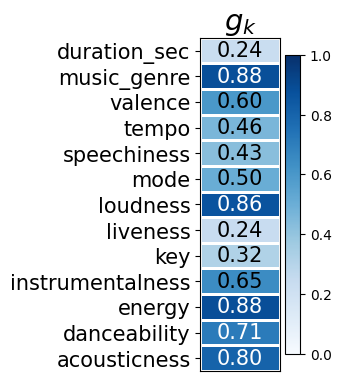

In [67]:
global_correlation, global_labels = features_train.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Blues", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

Больше всех со всеми остальными признаками коррелирует energy. Его оставим, а acousticness и loudness можно удалять

In [68]:
features_train = features_train.drop(['acousticness', 'loudness'], axis=1)
features_test = features_test.drop(['acousticness', 'loudness'], axis=1)
interval_cols.remove('acousticness')
interval_cols.remove('loudness')

Разборались с мультиколлинеарностью.

выделим из features_train жанры в целевой признак

In [69]:
target_train = features_train['music_genre']
features_train = features_train.drop(['music_genre'], axis=1)

Проверим целевой класс на дисбаланс

music_genre
Blues          0.142581
Electronic     0.129222
Alternative    0.124651
Rap            0.115508
Country        0.105146
Rock           0.101895
Anime          0.096256
Classical      0.069589
Jazz           0.062173
Hip-Hop        0.052979
Name: proportion, dtype: float64


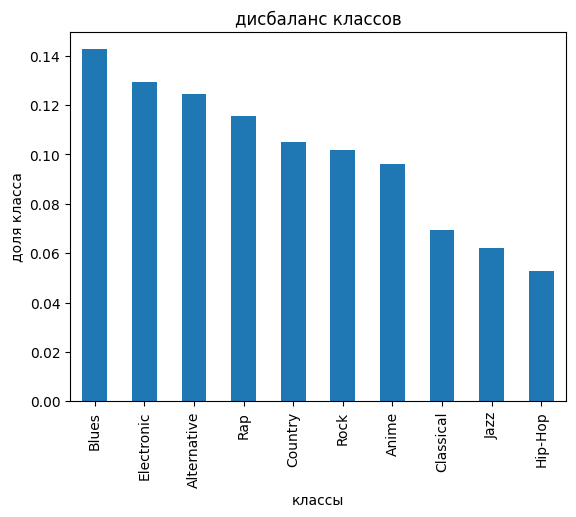

In [70]:
music_genre = target_train.value_counts(normalize=True)
print(music_genre)
music_genre.plot(kind='bar', title='дисбаланс классов', xlabel='классы', ylabel='доля класса')
plt.show();

 Закодируем категориальные признаки и решим проблему дисбаланса.

### Шаг 3. Кодирование и масштабирование признаков

In [71]:
#категориальные признаки для OHE
ohe_features = ['mode', 'key', 'liveness', 'speechiness']

# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[encoder_ohe.get_feature_names_out()] = \
    encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)
features_train.head()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,danceability,energy,instrumentalness,tempo,valence,duration_sec,mode_Minor,key_A#,key_B,key_C,...,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_unknown,liveness_recorded,speechiness_musical,speechiness_vocal
0,0.670,0.351,0.017600,101.384,0.450,182.653,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.452,0.670,0.000051,113.071,0.539,187.133,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.454,0.804,0.000974,80.980,0.344,173.448,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.847,0.873,0.000003,116.007,0.966,255.987,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.742,0.575,0.000002,76.494,0.583,195.333,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [72]:
features_test[encoder_ohe.get_feature_names_out()] = \
    encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)
features_test.head()

,danceability,energy,instrumentalness,tempo,valence,duration_sec,mode_Minor,key_A#,key_B,key_C,...,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_unknown,liveness_recorded,speechiness_musical,speechiness_vocal
0,0.757,0.679,0.00593,90.361,0.895,146.213,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.256,0.523,0.00832,78.385,0.318,240.360,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.678,0.770,0.00593,90.000,0.412,284.000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.592,0.749,0.00593,160.046,0.614,177.354,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.421,0.447,0.01480,73.830,0.121,226.026,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


боремся с дисбалансом методом SMOTE

In [73]:
smote = SMOTE(random_state=12345)
features_train, target_train = smote.fit_resample(features_train, target_train)

music_genre
Country        0.1
Rock           0.1
Alternative    0.1
Hip-Hop        0.1
Blues          0.1
Jazz           0.1
Electronic     0.1
Anime          0.1
Rap            0.1
Classical      0.1
Name: proportion, dtype: float64


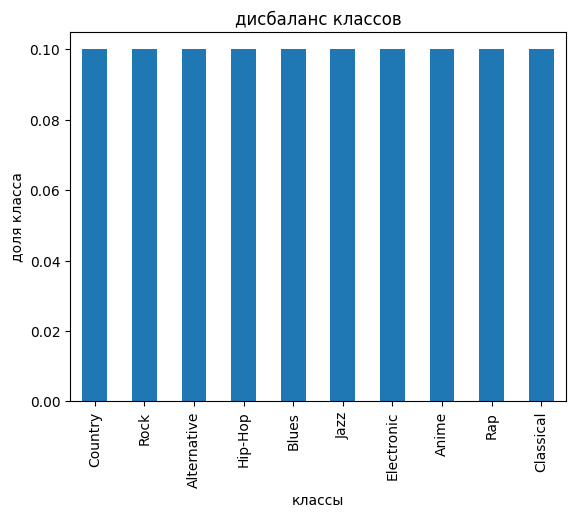

In [74]:
music_genre = target_train.value_counts(normalize=True)
print(music_genre)
music_genre.plot(kind='bar', title='дисбаланс классов', xlabel='классы', ylabel='доля класса')
plt.show();

Смасштабируем числовые признаки. Нормализовывать будем те, которые не находятся в диапазоне от 0 до 1

In [75]:
scaler = StandardScaler()

numeric_features = interval_cols
features_train[numeric_features] = scaler.fit_transform(features_train[numeric_features])
features_test[numeric_features] = scaler.transform(features_test[numeric_features])

In [76]:
features_train.head()

,danceability,energy,instrumentalness,tempo,valence,duration_sec,mode_Minor,key_A#,key_B,key_C,...,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_unknown,liveness_recorded,speechiness_musical,speechiness_vocal
0,0.633224,-0.966878,-0.551008,-0.608505,-0.023696,-0.573316,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.610290,0.275359,-0.606694,-0.223053,0.352411,-0.531844,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-0.598882,0.797177,-0.603764,-1.281454,-0.471644,-0.658529,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.642866,1.065874,-0.606845,-0.126220,2.156881,0.105551,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1.043926,-0.094586,-0.606849,-1.429408,0.538352,-0.455935,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Теперь закодируем целевой признак

In [77]:
label_encoder = LabelEncoder()
target_train = label_encoder.fit_transform(target_train)
target_train

array([4, 9, 0, ..., 9, 9, 9])

### Шаг 4. Разработка модели ML

In [78]:
def get_score(model, features, target):
    scores = cross_val_score(model, features, target, scoring="f1_micro", cv=5) 
    return sum(scores) / len(scores)

In [79]:
def get_optimal_decision_tree_classifier_description(features_train, target_train):
    best_score = 0
    best_depth = 0
    best_min_samples_leaf = 0
    for min_samples_leaf in range(1, 6):
        for depth in range(1,11):
            model = DecisionTreeClassifier(
                random_state=12345,
                max_depth=depth,
                min_samples_leaf=min_samples_leaf)
            score = get_score(model, features_train, target_train)
            if (score > best_score):
                best_score = score
                best_depth = depth
                best_min_samples_leaf = min_samples_leaf
    return {
        'score': best_score,
        'params': {
            'max_depth': best_depth,
            'min_samples_leaf': min_samples_leaf
        }
    }

In [80]:
def get_optimal_logistic_regression_description(features_train, target_train):
    model = LogisticRegression(
        multi_class='multinomial',
        max_iter=1000,
        random_state=12345)
    return {
        'score': get_score(model, features_train, target_train),
        'params': None
    }

In [81]:
def get_optimal_random_forest_classifier_description(features_train, target_train):
    best_score = 0
    best_est = 0
    best_depth = 0
    best_min_samples_leaf = 0
    #не успеваю сделать поиск параметров, т.к. делаю работу поздно вечером
    #а отчет отправить надо
    #поэтому намеренно сужаю диапазон поиска
    for min_samples_leaf in range(5, 6, 1):
        for est in range(50, 71, 10):
            for depth in range (8, 12, 2):
                model = RandomForestClassifier(
                    random_state=12345, 
                    n_estimators=est, 
                    max_depth=depth, 
                    min_samples_leaf=min_samples_leaf)
                
                score = get_score(model, features_train, target_train)
                if (score > best_score):
                    best_score = score
                    best_est = est
                    best_depth = depth
                    best_min_samples_leaf = min_samples_leaf
    return {
        'score': best_score,
        'params': {
            'n_estimators': best_est, 
            'max_depth': best_depth,
            'min_samples_leaf': best_min_samples_leaf
        }
    }

In [82]:
def get_optimal_catboost_classifier_description(features_train, target_train):
    train_pool = Pool(features_train, target_train)
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 250, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 4),
            'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 2.5, 4),
            'random_strength': trial.suggest_float('random_strength', 0.9, 1.4),
            'learning_rate': trial.suggest_float("eta", 1e-2, 1e-1, log=True),
            'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 5),
            'random_state': trial.suggest_categorical('random_state', [12345]),
            'eval_metric': trial.suggest_categorical('eval_metric', ['TotalF1:average=Micro']),
            "loss_function": trial.suggest_categorical('loss_function', ['MultiClass']),
            'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
            }

        scores = cv(train_pool, params, fold_count=5)
        return scores['test-TotalF1:average=Micro-mean'].values[-1]

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1e6, timeout=60*1)
    return {
        'score': study.best_trial.value,
        'params': study.best_trial.params
    }

In [83]:
def analisys(features_train, target_train):
    return [
        {
            'Тип': 'Логистическая регрессия',
            **get_optimal_logistic_regression_description(features_train, target_train)
        },
        {
            'Тип': 'Решающее дерево',
            **get_optimal_decision_tree_classifier_description(features_train, target_train)
        },
        {
            'Тип': 'Случайный лес',
            **get_optimal_random_forest_classifier_description(features_train, target_train)
        },
        {
            'Тип': 'Catboost',
            **get_optimal_catboost_classifier_description(features_train, target_train)
        }
    ]

In [84]:
def make_table(data):
    df = pd.DataFrame(data = data);
    with pd.option_context('display.precision', 3):
        style = df.style.background_gradient('coolwarm')
    return style

In [85]:
# сохраним в перееменную, для итогового анализа
result = analisys(features_train, target_train)

In [86]:
make_table(result)

,Тип,score,params
0,Логистическая регрессия,0.407410,None
1,Решающее дерево,0.544532,"{'max_depth': 10, 'min_samples_leaf': 5}"
2,Случайный лес,0.578767,"{'n_estimators': 70, 'max_depth': 10, 'min_samples_leaf': 5}"
3,Catboost,0.605453,"{'n_estimators': 255, 'max_depth': 3, 'l2_leaf_reg': 2.9664937745357505, 'random_strength': 1.1270830767651967, 'eta': 0.05311504829849082, 'min_data_in_leaf': 5, 'random_state': 12345, 'eval_metric': 'TotalF1:average=Micro', 'loss_function': 'MultiClass', 'logging_level': 'Silent'}"


Лучший результат у catboost.

In [87]:
params = {'n_estimators': 482, 'max_depth': 4, 'l2_leaf_reg': 3.303532893177284, 'random_strength': 1.0685831400944628, 'eta': 0.06360183429810953, 'min_data_in_leaf': 2, 'random_state': 12345, 'eval_metric': 'TotalF1:average=Micro', 'loss_function': 'MultiClass', 'logging_level': 'Silent'}
model = CatBoostClassifier(
    **params
)

model.fit(
    features_train, target_train,
    verbose=False
)

In [88]:
target_test = label_encoder.inverse_transform(model.predict(features_test))
target_test

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['Hip-Hop', 'Alternative', 'Electronic', ..., 'Electronic',
       'Electronic', 'Blues'], dtype=object)

In [89]:
result = pd.DataFrame()
result['instance_id'] = data_test['instance_id'].astype('Int64')
result['music_genre'] = target_test
result.head()

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Electronic
3,78331,Blues
4,72636,Alternative


In [90]:
result.to_csv('/kaggle/working/submit.csv', index=False)

# Вывод

К сожалению я не все успел, что хотел. И считаю, что не справился с заданием.
Слишком много тем в этом блоке было не разобрано в теоретической части, которые пришлось изучать самостоятельно. <br/>
У меня на выходе получался очень маленькое значение f1_micro, по сравнению с другими участниками соревнования, и я почему-то решил, что дело в том, что они все используют catboost. Поэтому я очень много времени потратил на изучение catboost, видимо зря. Потому что catboost дал мне тоже малый итог.<br/>
В соревновании я набрал 0.44409 - но это неосознанный результат, который получился в результате экспериментов. Причем Kaggle дал сбой и я потерял результат работы за 3 дня. Как я добился 0.44409 я так и не понял - повторить не успел.<br/>
Последний результат, который я отправил дал 0.36445.<br/>
Возможно надо было разбираться с важностью признаков, или я еще чего-то не понял.<br/>
Дальше просто не хватило времени.<br/>
вопросов больше чем ответов.
<br/><br/>
Что сделал:<br/>
1. Разобрался с дубликатами.<br/>
2. Заполнил пропуски<br/>
3. Проверил признаки на мультиколлинеарность.<br/>
4. Провел работу с дисбалансом<br/>
5. Методом кроссвалидации проверил 4 модели. Немного разобрался с catboost.<br/>
6. Получил на тренировочной выборке 0.649981, но на тестовой этот результат сильно меньше. К сожалению не понял почему так произошло. В чате тоже народ писал, что у них на обучающей выборке метрика больше.<br/>
7. На самом деле получил много удовольствия от участия в соревновании. Оно подсветило много областей для дальнейшего изучения.
